### Transfer Learning MobileNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../files_detour.csv',index_col=0)

In [3]:
src_img = '../images_detour/'

In [5]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [6]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [7]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [8]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour/BA_102750.jpg,BA_102750.jpg,basophil,0


In [9]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [10]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) # format nécessaire pour MobileNet
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [13]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [14]:
# Création d'un modèle MobileNet
def model_mobileNet():
    base_model = MobileNet(
        weights='imagenet',  
        input_shape=(224, 224, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.5)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = model_mobileNet()

In [16]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 824s 1s/step - loss: 1.0055 - accuracy: 0.6682 - val_loss: 0.6230 - val_accuracy: 0.7884
Epoch 2/16
800/800 [==============================] - 791s 988ms/step - loss: 0.6983 - accuracy: 0.7786 - val_loss: 0.4990 - val_accuracy: 0.8380
Epoch 3/16
800/800 [==============================] - 839s 1s/step - loss: 0.6338 - accuracy: 0.8025 - val_loss: 0.4442 - val_accuracy: 0.8619
Epoch 4/16
800/800 [==============================] - 813s 1s/step - loss: 0.5969 - accuracy: 0.8146 - val_loss: 0.4436 - val_accuracy: 0.8531
Epoch 5/16
800/800 [==============================] - 822s 1s/step - loss: 0.5678 - accuracy: 0.8245 - val_loss: 0.4337 - val_accuracy: 0.8608
Epoch 6/16
800/800 [==============================] - 786s 983ms/step - loss: 0.5529 - accuracy: 0.8297 - val_loss: 0.4445 - val_accuracy: 0.8555
Epoch 7/16
800/800 [==============================] - 829s 1s/step - loss: 0.5282 - accuracy: 0.8375 - val_loss: 0.4292 - val_accuracy: 

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [25]:
for layer in model.layers[-17:]: 
    layer.trainable = True

In [26]:
for layer in model.layers: 
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False


##### Fine Tunning

In [28]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
callback = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 1089s 1s/step - loss: 0.7855 - accuracy: 0.7658 - val_loss: 0.4645 - val_accuracy: 0.8555
Epoch 2/16
800/800 [==============================] - 1069s 1s/step - loss: 0.5827 - accuracy: 0.8205 - val_loss: 0.4193 - val_accuracy: 0.8692
Epoch 3/16
800/800 [==============================] - 1068s 1s/step - loss: 0.5350 - accuracy: 0.8401 - val_loss: 0.3966 - val_accuracy: 0.8742
Epoch 4/16
800/800 [==============================] - 1055s 1s/step - loss: 0.4958 - accuracy: 0.8518 - val_loss: 0.3750 - val_accuracy: 0.8808
Epoch 5/16
800/800 [==============================] - 1054s 1s/step - loss: 0.4848 - accuracy: 0.8576 - val_loss: 0.3676 - val_accuracy: 0.8812
Epoch 6/16
800/800 [==============================] - 1063s 1s/step - loss: 0.4557 - accuracy: 0.8651 - val_loss: 0.3640 - val_accuracy: 0.8844
Epoch 7/16
800/800 [==============================] - 1052s 1s/step - loss: 0.4424 - accuracy: 0.8692 - val_loss: 0.3515 - val_accuracy:

In [14]:
model.save_weights("mobilenet_detour_weights")

#### Prédiction sur les données d'évaluation

In [15]:
model = model_mobileNet()
model.load_weights("mobilenet_detour_weights")

In [30]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [31]:
model.evaluate(dataset_eval)

99/99 [==============================] - 84s 847ms/step - loss: 0.3692 - accuracy: 0.8877


[0.3692170977592468, 0.8876937627792358]

 * Bon score de 88,8, légère amélioration en fine tuning

In [32]:
#Classes prédites
predict = model.predict(dataset_eval)

In [33]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.94      0.88      0.91       119
       blast       0.81      0.93      0.87       327
  eosinophil       0.95      0.96      0.95       323
erythroblast       0.89      0.96      0.92       210
          ig       0.87      0.73      0.79       381
  lymphocyte       0.88      0.91      0.89       453
    monocyte       0.81      0.81      0.81       274
  neutrophil       0.94      0.93      0.94       573
    platelet       1.00      0.99      0.99       242
      smudge       0.80      0.78      0.79       259

    accuracy                           0.89      3161
   macro avg       0.89      0.89      0.89      3161
weighted avg       0.89      0.89      0.89      3161



> Rappel plus faible sur les IG toujours, ainsi que les monocytes
>
> Score plus faible sur blast et smudge, compréhensible par des différences importantes sur ces types

In [34]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,105,1,1,0,3,3,2,2,0,2
blast,0,304,0,0,3,5,10,0,0,5
eosinophil,0,0,310,1,3,1,0,7,0,1
erythroblast,0,0,0,201,0,7,0,2,0,0
ig,4,40,3,2,278,9,19,11,0,15
lymphocyte,1,7,1,17,1,413,6,0,0,7
monocyte,0,13,0,1,10,9,222,2,0,17
neutrophil,1,1,11,2,15,5,4,533,0,1
platelet,0,0,0,1,0,0,0,0,239,2


> Confusion importante blaste/IG ainsi que monocyte/IG

In [35]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [36]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

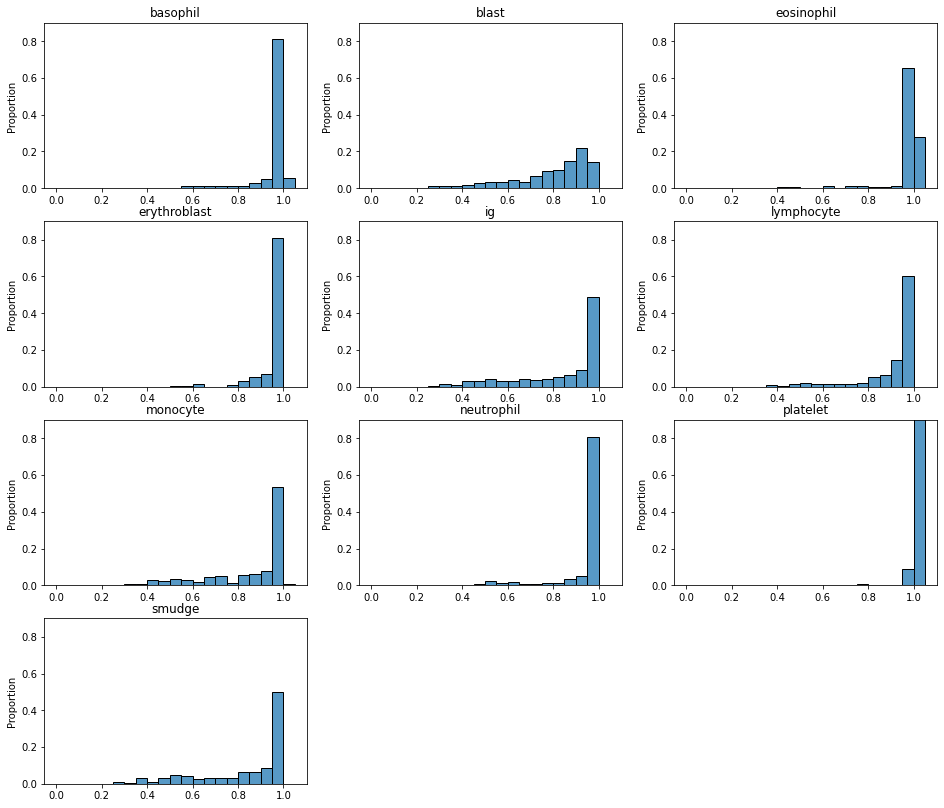

In [37]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Les prédictions sont faites avec un pourcentage de confiance supérieur à 80% pour tous les types sauf les blastes

In [51]:
# Récupère les cellules mal prédites => regarde la proba sur la classe prédite
predict_no_correct = compare[compare['Réalité']!=compare['Prédiction']]

In [53]:
predict_by_class = []
for i in range(10):
    indexes = predict_no_correct[predict_no_correct['Prédiction']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

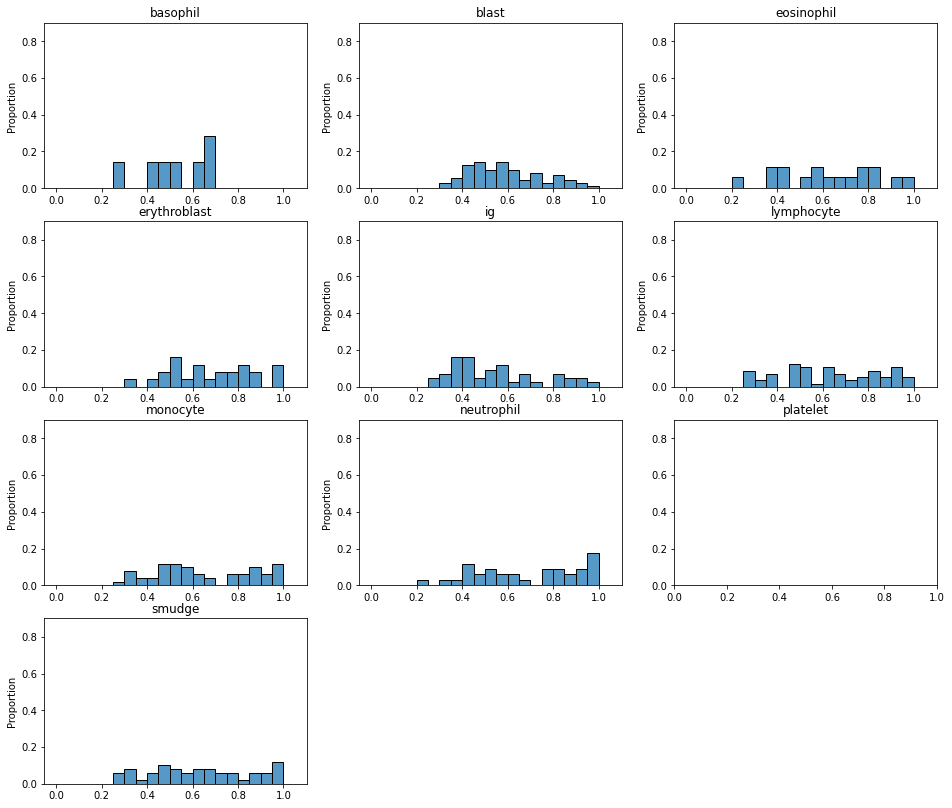

In [54]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Sur les cellules avec erreurs de classes, le pourcentage sur la classe erronée est cependant important


### GRAD CAM

In [38]:
import gradcam_dataset

In [39]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [40]:
img_size = (255, 255)
last_conv_layer_name = "conv_pw_13"

##### BASOPHIL

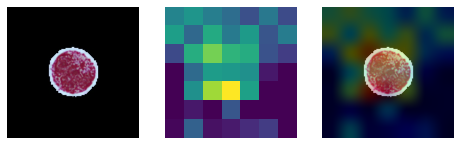

In [41]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

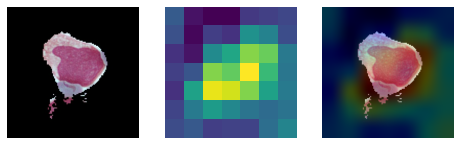

In [42]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

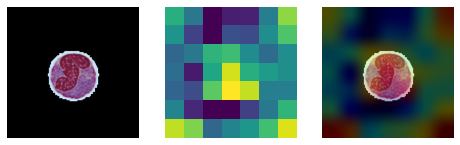

In [43]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

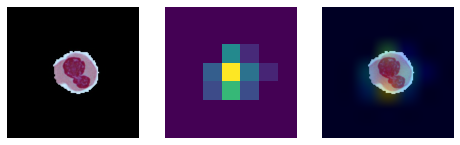

In [44]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

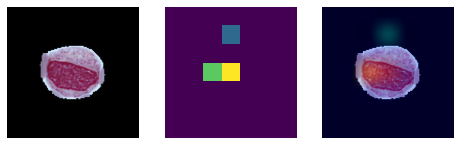

In [45]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

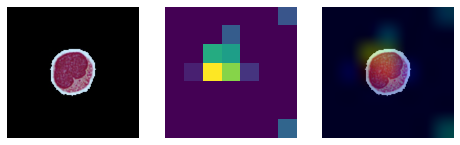

In [46]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

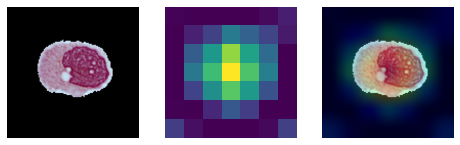

In [47]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

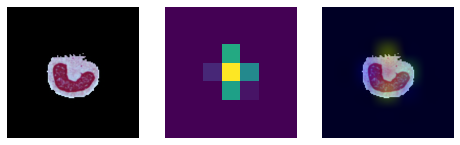

In [48]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

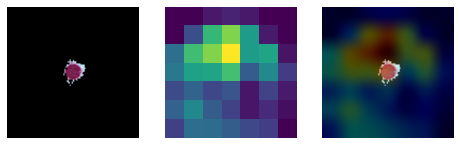

In [49]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

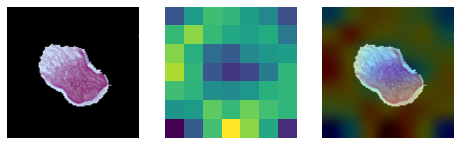

In [50]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)

> Prise en compte de zone en dehors de la cellule pour certains types, pas de réelles améliorations avec le détourage
>
> Problème d'analyse????